### Imports

In [47]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Load data from Bigquery

In [48]:
table = 'eth-tokens.test.clean_avg_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [222]:
sql = '''
SELECT *  FROM `{}`
'''.format(table)

df = client.query(sql).to_dataframe()

In [50]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [589]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 40
# num_features = 15

In [590]:
log = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters, n_init=20, max_iter=500,n_jobs=-1, verbose=1)

#build pipeline
pipe = Pipeline([('log', log ),
                 ('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




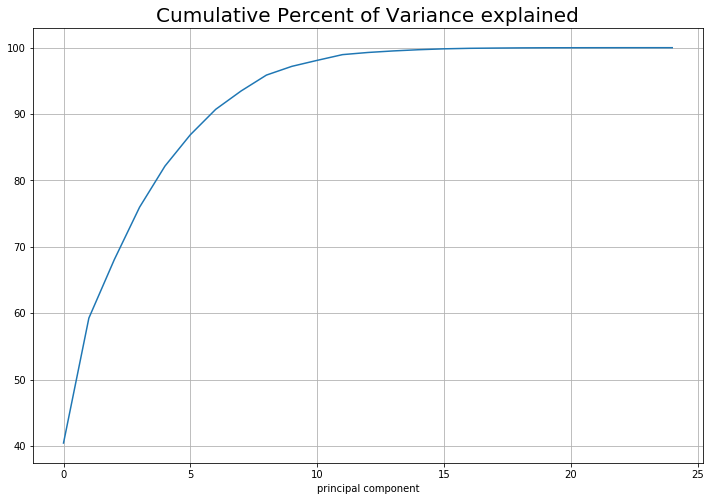

In [632]:
#percent of variance explained by each component
fig = plt.figure(figsize=(12,8))
plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained',fontsize=20)
plt.show()

### Choose number of clusters with Calinski-Harabaz, Elbow Plot

In [8]:
# #scoring metric?
# from sklearn.metrics import calinski_harabaz_score as ch_score
# clusters = [3,5,8,10,15,20,30,40,60,80]
# scores = []
# inertias = []
# for c in clusters:
#     cl_n = KMeans(c).fit(results)
#     score = ch_score(results, cl_n.labels_)
#     scores.append(score)
#     inertias.append(cl_n.inertia_)


# plt.plot(clusters, scores)
# plt.title('Calinski Harabaz Scores')

In [9]:
# #elbow plot
# plt.plot(clusters,inertias)
# plt.title('Elbow plot')
# plt.ylabel('within cluster sum of squares')

## Optimal clusters

In [592]:

cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=40, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
# %run silhouette_plotter.py
# X=results
# range_n_clusters = [20]
# if len(newresults) <20000:
#     silhouette_plotter(X, range_n_clusters)

In [56]:
# #subset results for tsne
# #address mask needed for later superposition
# max_size = len(results)
# subset_results = []
# lbls = []
# address_mask = np.array([False for addr in df['address']]) 
# for c in np.unique(cl.labels_):
#     mask = (cl.labels_==c)
#     c_size = np.sum(mask)
#     if c_size < max_size:
#         lbls.extend(list(cl.labels_[cl.labels_==c]))
#         subset_results.append(results[mask])
#         address_mask |= mask
# lbls=np.array(lbls)
# subset_results=np.vstack(subset_results)

In [593]:
#not using subset
subset_results = results
lbls = cl.labels_

In [58]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.039s...
[t-SNE] Computed neighbors for 35917 samples in 25.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

In [594]:
#setting up color map
NUM_COLORS = cl.n_clusters
cm = plt.get_cmap('nipy_spectral')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  after removing the cwd from sys.path.


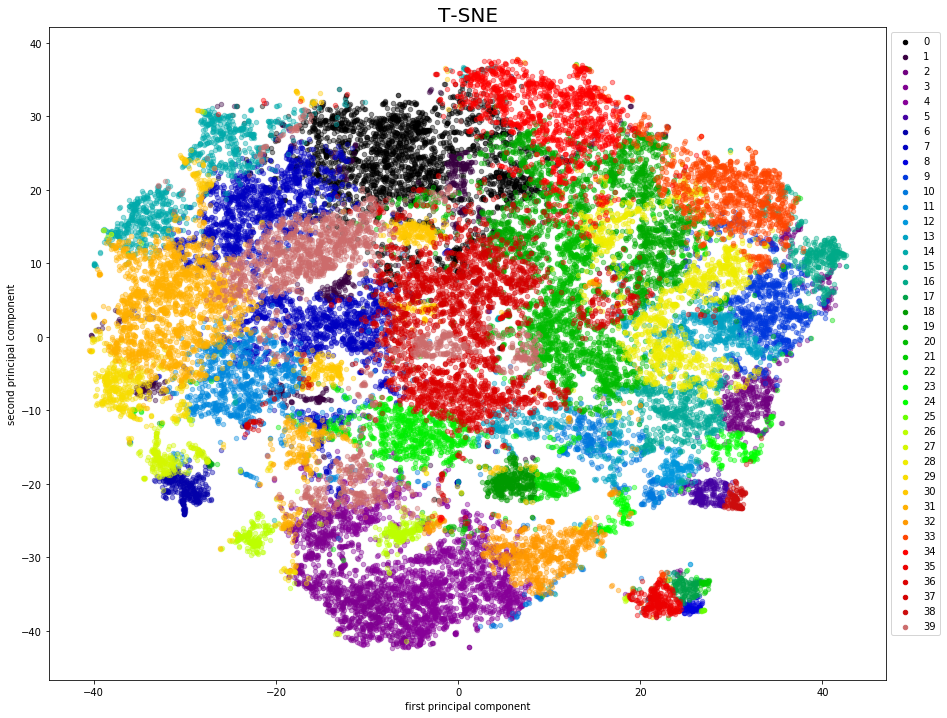

In [634]:
#color coded by cluster
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=20, alpha=.4,label=lbl)
    
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)




plt.title('T-SNE', fontsize=20)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

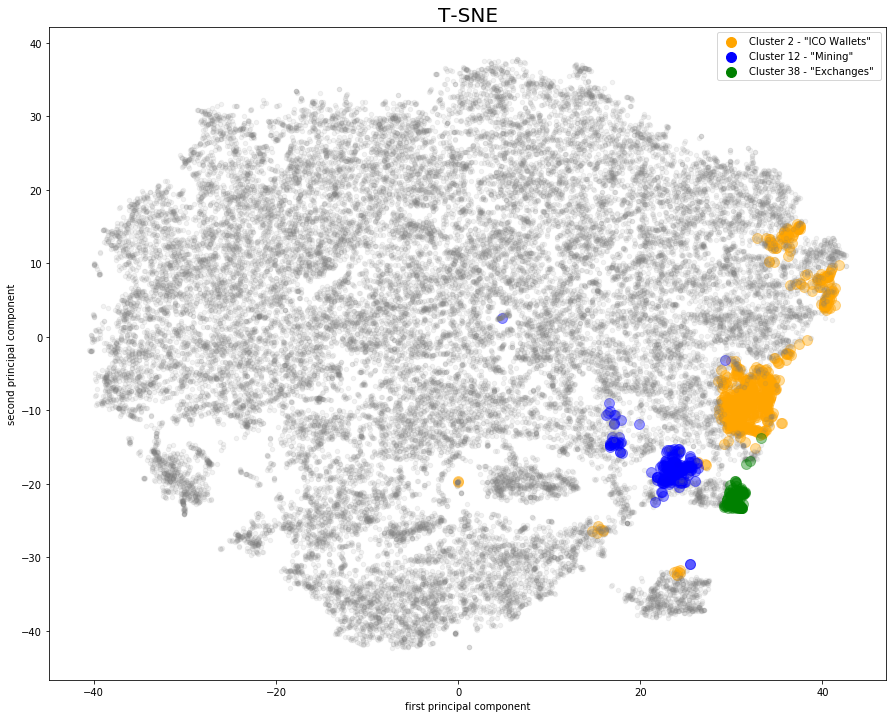

In [650]:
#highlighting clusters of interest
clusters = (38,12,2)
categ = ('Exchanges', 'Mining', 'ICO Wallets')
colors = ('green', 'blue', 'orange')

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)


for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    
    if c in clusters:
        idx = clusters.index(c)
        lbl = categ[idx]
        color = colors[idx]
        
        plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=100,c=color,alpha=.4,label=('Cluster {} - "{}" '.format(c,lbl) ))
    else:
         plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], c='gray',s=20, alpha=.1)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)




plt.title('T-SNE', fontsize=20)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## Label centroids with cluster

In [597]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = log.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [598]:
#put cluster sizes into summary dataframe
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [599]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
7,5.654559,7.581786,34.687310,6.376662,1.878441e+04,3376.220312,100.643297,13.668558,4.310588e+04,5781.884459,...,3.091681e+03,-1.040834e-17,8.326673e-17,2.494507e+06,3.472436e+06,2.906898e+06,3.676120e+06,10.566866,60.295403,2661
0,7.347926,8.969837,158.161654,22.145139,6.941805e+04,9638.295487,293.620775,33.582299,8.261263e+04,9392.625953,...,4.605196e+03,2.701640e-04,4.282336e-04,2.716489e+06,4.161121e+06,3.103477e+06,4.281959e+06,16.212944,103.792334,2566
19,7.915171,8.634954,473.835850,61.336929,2.551985e+05,32895.250388,816.682183,96.757907,3.765313e+05,44495.004658,...,2.749418e+04,8.463256e-04,8.463256e-04,1.770261e+06,2.657469e+06,1.881302e+06,2.574607e+06,11.906670,224.871524,2118
39,17.798371,23.545916,67.599490,4.055264,3.203967e+04,1818.541940,143.577680,6.390411,5.154622e+04,2208.827313,...,3.209007e+03,3.334597e-04,3.334597e-04,1.107190e+06,1.796628e+06,1.237822e+06,2.042176e+06,19.818915,63.492963,2079
31,5.585525,9.878800,6.837962,1.367741,2.961667e+03,541.599256,62.263068,6.706584,2.031721e+04,2101.221685,...,1.339477e+03,2.373124e-03,2.770298e-03,1.866860e+06,2.696938e+06,2.921402e+06,3.704672e+06,12.656614,55.457471,2048
37,10.884929,12.646403,151.638656,14.434088,9.041047e+04,8477.466752,249.553154,20.337921,1.387454e+05,11178.059966,...,1.186504e+04,3.540704e-04,5.612465e-04,1.057934e+06,1.599332e+06,8.584879e+05,1.222701e+06,9.497821,85.402859,1959
4,12.872105,296.848251,88.926910,7.376853,4.723449e+04,3766.823022,179.831524,0.711073,8.348956e+04,281.816230,...,5.954202e+03,2.115335e-03,2.272711e-03,1.039041e+05,8.145142e+04,1.412662e+06,1.818811e+06,11.306722,72.684057,1832
20,37.741125,38.050129,432.014432,11.750721,2.064267e+05,5496.120414,555.029927,14.947361,2.159065e+05,5707.324831,...,1.348155e+04,-1.526557e-16,-1.804112e-16,7.763555e+05,1.476698e+06,7.296841e+05,1.378616e+06,27.424676,91.996449,1790
3,7.637286,181.675374,11.260289,1.713056,5.744399e+03,773.754158,68.346247,0.468538,3.170934e+04,175.190387,...,2.548979e+03,1.461349e-03,1.746542e-03,1.512446e+05,1.093325e+05,1.665765e+06,1.783616e+06,8.548379,52.063250,1424
34,12.389653,13.226475,866.563494,71.945572,1.857476e+05,15317.757185,1357.251374,106.093850,7.093078e+04,5493.210477,...,2.895401e+03,4.430770e-03,7.970691e-03,1.971762e+06,3.561835e+06,2.713180e+06,4.527075e+06,19.809361,404.086682,1346


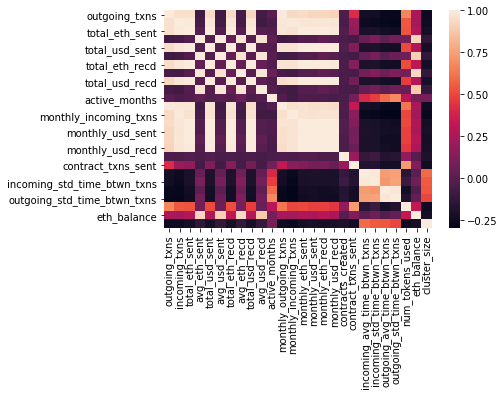

In [628]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [629]:
arr = df_summary.values

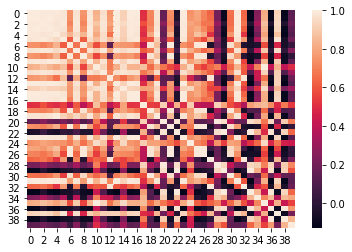

In [630]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

## Review Etherscan Labels

In [603]:
sql = '''
SELECT es.label,es.category, a.*  FROM `{}` a
INNER JOIN `{}` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''.format(table, label_table)

dflabel = client.query(sql).to_dataframe()

In [604]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [605]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [606]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label','category']])
    print('\n\n\n')

cluster 0
labelled points: 0
total points: 2566
Empty DataFrame
Columns: [label, category]
Index: []




cluster 1
labelled points: 0
total points: 662
Empty DataFrame
Columns: [label, category]
Index: []




cluster 2
labelled points: 8
total points: 570
                  label     category
14     Perlin_TokenSale   Token Sale
17      Airbloc_Wallet2  ICO Wallets
18        Rate3_Wallet1  ICO Wallets
31  Lendingblock_Wallet  ICO Wallets
35         Zebi_Wallet2  ICO Wallets
47       CPChain_Wallet  ICO Wallets
68     Credits_MultiSig  ICO Wallets
70          HOQU_Wallet  ICO Wallets




cluster 3
labelled points: 2
total points: 1424
                    label    category
25       Fake_Phishing631  Phish/Hack
45  EuropeanCryptoBankICO  Token Sale




cluster 4
labelled points: 2
total points: 1832
               label    category
32  Fake_Phishing638  Phish/Hack
33  Fake_Phishing429  Phish/Hack




cluster 5
labelled points: 8
total points: 248
            label    category
0         Bgo

centralization of ownership

In [607]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

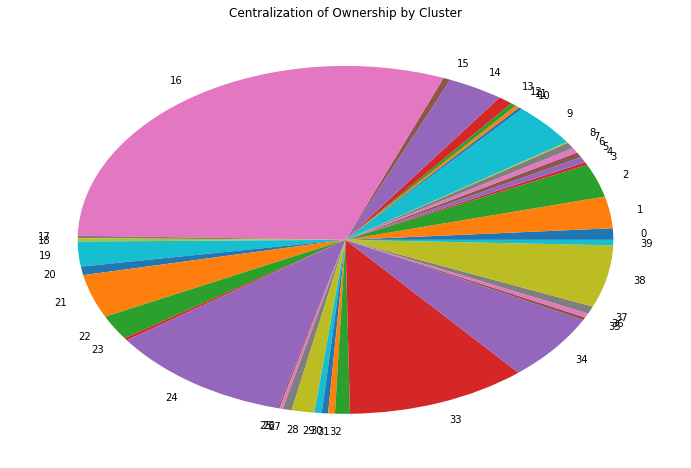

In [608]:
fig = plt.figure(figsize=(12,8))
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

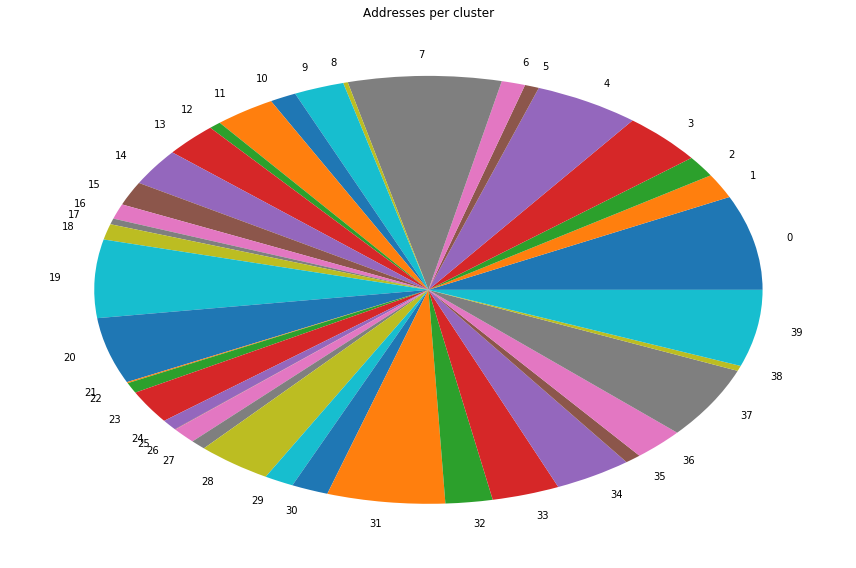

In [609]:
fig = plt.figure(figsize=(12,8))
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.tight_layout()
plt.show()

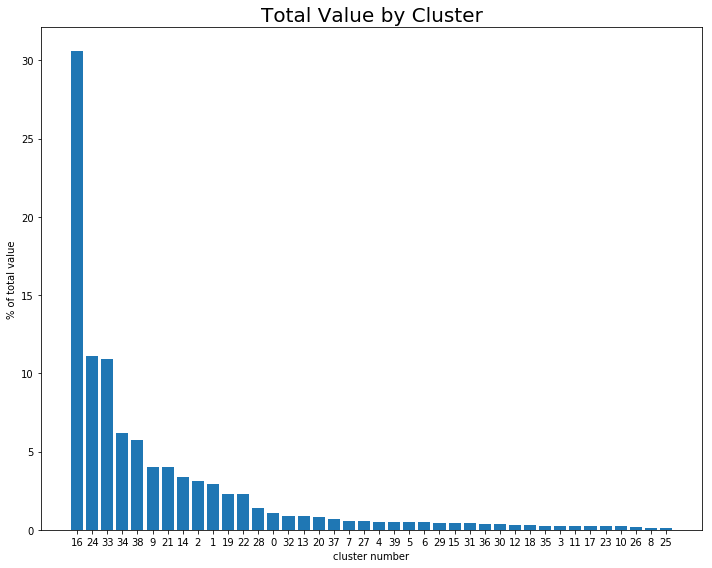

In [675]:
fig = plt.figure(figsize=(10,8))
names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster', fontsize=20)
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




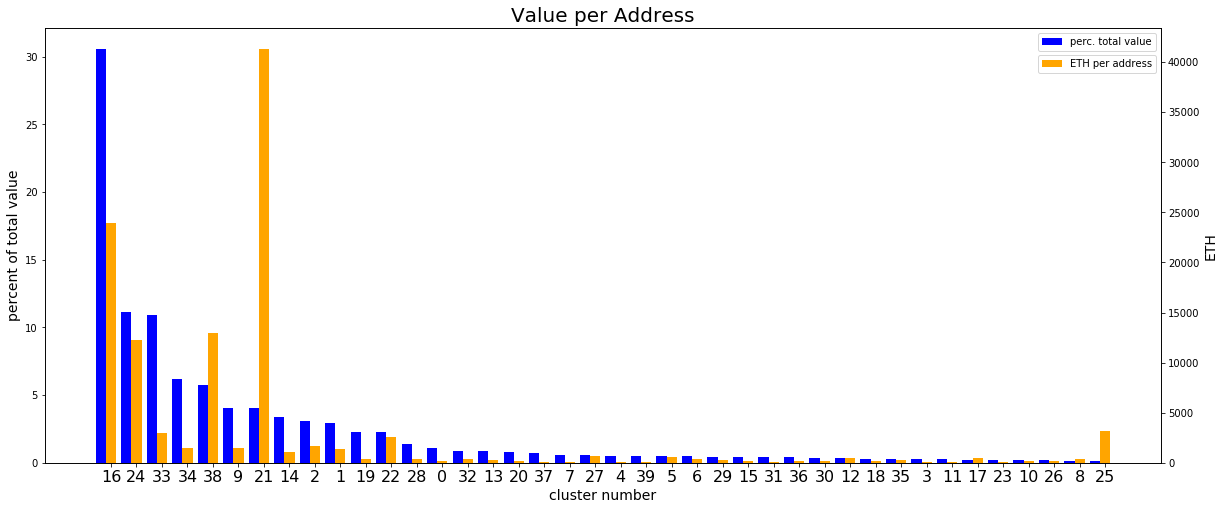

In [738]:
fig = plt.figure(figsize=(20,8))
names = np.array(list(total_addresses.keys()))
eth_values = np.array(list(total_eth.values()))
addr_values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
eth_values = eth_values[indices][::-1]
addr_values = addr_values[indices][::-1]

ax = fig.add_subplot(111)
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ind = np.array(range(len(total_eth)))

#tick_label does the some work as plt.xticks()
ax.bar(ind,values/sum(values)*100,tick_label=names, color='blue', width=.4, label='perc. total value')
ax2.bar(ind+.4,eth_values/addr_values,tick_label=names, color='orange', width=.4, label='ETH per address')
ax.set_title('Value per Address',fontsize=20)
# plt.yscale('log')
ax.set_xlabel('cluster number', fontsize=14)
ticks = ax.get_xmajorticklabels()
ax.set_xticklabels(ticks, fontsize=16)
ax.set_ylabel('percent of total value', fontsize=14)
ax2.set_ylabel('ETH', fontsize=14)
ax.legend(bbox_to_anchor=(1, 1))
ax2.legend(bbox_to_anchor=(1, .95))
plt.show()

## Radar Plot

In [567]:
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
14,15847.449446,9546.742038,4.695420e+05,3.671209e+01,1.633141e+08,9.679751e+03,2.331401e+05,34.150677,5.622929e+07,6.237148e+03,...,3.715092e+06,-5.474055e-02,4.578741e+00,2.905329e+03,2.254777e+04,1.907986e+03,9.636144e+03,179.907400,6.913600e+03,5034
18,76850.583002,1480.371552,3.029098e+05,6.628523e+00,5.503567e+07,7.955399e+02,2.371218e+04,26.653144,5.142506e+06,3.744823e+03,...,3.008199e+05,4.423808e-01,1.323838e+00,3.065106e+04,1.185590e+05,2.817535e+02,3.168773e+03,71.234364,3.788066e+03,4101
11,2150.185960,1895.488339,1.593082e+04,1.078050e+01,4.830306e+06,2.654267e+03,1.298961e+04,11.201239,3.706953e+06,2.063707e+03,...,2.671420e+05,-1.244230e-01,3.624981e+00,9.779673e+03,5.232154e+04,7.907932e+03,3.617206e+04,65.013198,1.360970e+03,3510
6,486800.115233,14804.151180,7.144568e+06,1.744804e+01,1.783045e+09,3.581039e+03,9.439116e+05,52.582397,1.659769e+08,1.130125e+04,...,8.481816e+06,5.571069e-01,2.078790e+00,4.194603e+03,3.006546e+04,7.501766e+01,1.300292e+03,181.650327,9.706560e+03,3315
3,8875.573951,849.102308,2.037697e+06,1.914792e+02,6.210772e+08,8.714806e+04,7.073105e+06,6883.582411,2.978168e+09,3.318309e+06,...,2.280142e+08,3.020463e-01,9.304918e+00,1.782434e+04,1.495777e+05,3.543102e+03,2.819598e+04,61.420122,1.617519e+04,2926
5,2945.595606,71.719740,6.942648e+03,4.711232e+00,1.274181e+06,6.232535e+02,3.280012e+02,7.198463,7.832652e+04,1.197410e+03,...,6.388015e+03,2.672836e-01,5.187712e-01,2.426186e+05,5.999265e+05,4.330365e+03,2.010237e+04,13.861813,3.604535e+02,2840
9,778.792970,93.256191,7.290383e+04,1.371827e+02,3.288148e+07,4.045161e+04,5.022829e+03,71.931398,1.453715e+06,1.713447e+04,...,9.159332e+04,-1.821951e-01,8.017220e-02,2.678561e+05,1.049558e+06,6.544610e+04,7.534138e+04,96.473269,7.767373e+03,2780
17,11.229625,421.053780,3.127609e+02,3.986517e+01,8.466092e+04,9.997627e+03,2.975922e+03,6.195938,1.088549e+06,2.596629e+03,...,9.034890e+04,-6.143961e-02,2.433770e-01,2.205544e+04,1.923160e+05,1.229588e+06,1.446644e+06,13.787986,6.528973e+02,1846
4,327.832581,32.770850,6.098203e+04,1.979490e+02,2.137344e+07,6.540925e+04,4.244276e+05,8800.148789,1.256973e+08,3.657060e+06,...,1.101524e+07,5.161458e-02,6.950555e+00,3.056459e+05,9.923944e+05,6.128759e+04,2.203527e+05,20.519059,5.680572e+03,1715
0,122.996259,36965.480218,4.555071e+04,4.570050e+02,6.027880e+06,5.874695e+04,1.378211e+06,37.427807,2.902080e+08,7.736827e+03,...,1.888109e+07,2.118469e-01,-8.833042e-03,6.319747e+02,2.939036e+04,1.926926e+05,2.525546e+05,54.729625,6.165521e+03,1576


In [651]:
df_radar = df_summary.loc[list(clusters)]

In [652]:
df_radar['label'] = list(categ)

In [653]:
df_radar = df_radar.reset_index()

In [654]:
df_radar.set_index('label', inplace=True)

In [655]:
df_radar[df_radar<0] = 0

In [656]:
#log scale
df_radar = np.log1p(df_radar)+1

In [658]:
df_radar

,index,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
label,,,,,,,,,,,,,,,,,,,,,
Exchanges,4.663562,11.935071,10.472585,14.144831,3.422094,20.128871,9.194818,13.868193,4.533530,19.826562,...,17.248446,1.000000,1.000000,8.708519,10.840229,7.233249,9.456727,4.917723,8.516735,5.955827
Mining,3.564949,8.112938,4.908673,8.633715,2.287154,14.310053,7.256527,8.263216,4.488716,13.961135,...,12.070976,1.017884,1.017884,13.281337,13.805342,10.092151,11.571218,3.240952,5.918390,6.347108
ICO Wallets,2.098612,5.206352,5.476147,10.749402,6.569781,16.969195,12.784029,10.878585,6.425829,17.095501,...,14.562463,1.013263,1.032324,13.511728,14.370417,13.811393,14.487320,4.082472,7.130929,7.347389


In [659]:
# scale by max present per column

for col in df_radar.columns:
    df_radar[col] = [val/max(df_radar[col]) for val in df_radar[col]]

label with my name for category
round negative results in summary to zero


In [660]:
list(df_radar)[1:-1]

['outgoing_txns',
 'incoming_txns',
 'total_eth_sent',
 'avg_eth_sent',
 'total_usd_sent',
 'avg_usd_sent',
 'total_eth_recd',
 'avg_eth_recd',
 'total_usd_recd',
 'avg_usd_recd',
 'active_months',
 'monthly_outgoing_txns',
 'monthly_incoming_txns',
 'monthly_eth_sent',
 'monthly_usd_sent',
 'monthly_eth_recd',
 'monthly_usd_recd',
 'contracts_created',
 'contract_txns_sent',
 'incoming_avg_time_btwn_txns',
 'incoming_std_time_btwn_txns',
 'outgoing_avg_time_btwn_txns',
 'outgoing_std_time_btwn_txns',
 'num_tokens_used',
 'eth_balance']

In [661]:
feats = ['eth_balance','outgoing_txns','outgoing_avg_time_btwn_txns','total_usd_sent',
            'incoming_txns','incoming_avg_time_btwn_txns','total_usd_recd', 
            'num_tokens_used','contracts_created' ]

In [662]:
df_radar = df_radar[feats]

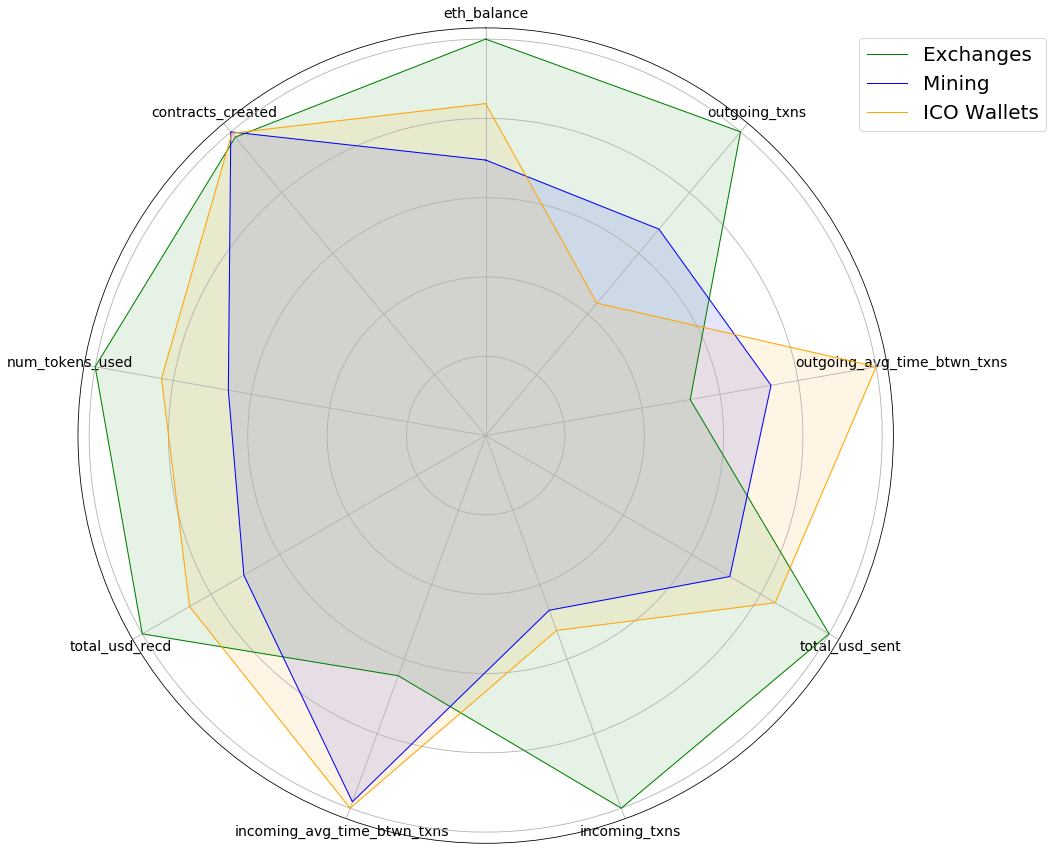

In [663]:
# Libraries
from math import pi

 
fig = plt.figure(figsize=(15,15))
# ------- PART 1: Create background
 
# number of variable
categories=list(df_radar)

N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
plt.xticks(fontsize=14)
# Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
# plt.ylim(0,40)
ax.set_yticklabels([])
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
for i in range(3):
    # Ind1
    lbl = categ[i]
    values=df_radar.loc[lbl].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, c=colors[i],linestyle='solid', label=lbl)
    ax.fill(angles, values, c=colors[i], alpha=0.1)
 
 
# Add legend
plt.legend(fontsize=20,loc='upper right', bbox_to_anchor=(1.2, 1))

In [664]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

In [665]:
labelcl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [labelcl.labels_[i] for i in range(len(dflabel))]

In [666]:
time_start = time.time()
tsne_label = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results_label = tsne_label.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 126 samples in 0.000s...
[t-SNE] Computed neighbors for 126 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 126 / 126
[t-SNE] Mean sigma: 2.187383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.834194
[t-SNE] KL divergence after 1600 iterations: 0.309203
t-SNE done! Time elapsed: 0.670196533203125 seconds


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


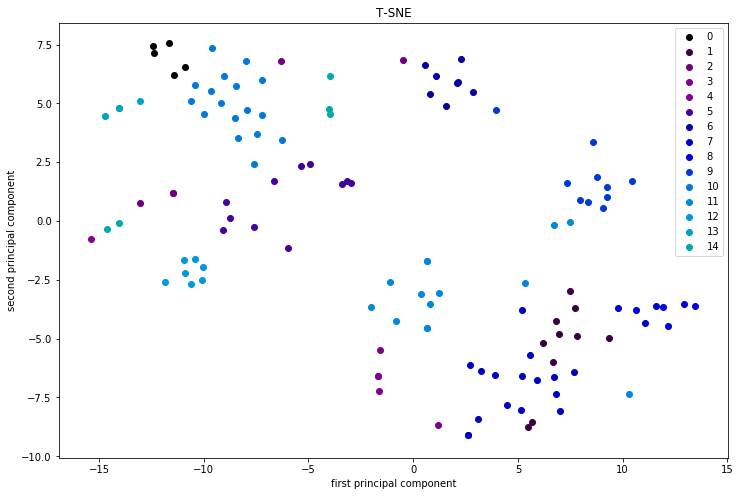

In [667]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in np.unique(labelcl.labels_):
    mask = labelcl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


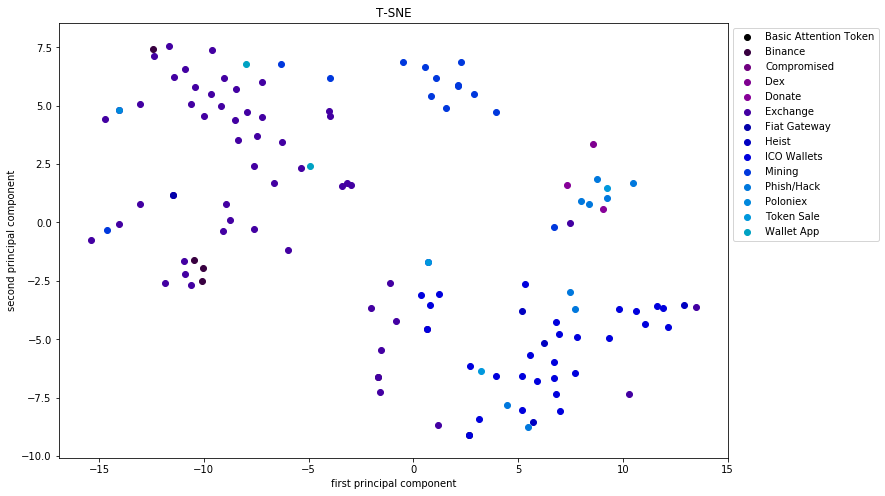

In [668]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## subset original T-SNE results
create a mask for all points that are labelled

In [404]:
labeled_addresses = dflabel['address'].values
labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )

# #labelmask for subset results!!!
# labelmask = np.array([addr in labeled_addresses for addr in df['address'][address_mask]] )

In [405]:
#helper function for category mask
def cat(addr, labeled_addresses, dflabel):
    if addr not in labeled_addresses:
        return False
    else:
        idx = int(np.where(labeled_addresses==addr)[0][0])
        return dflabel['category'][idx]

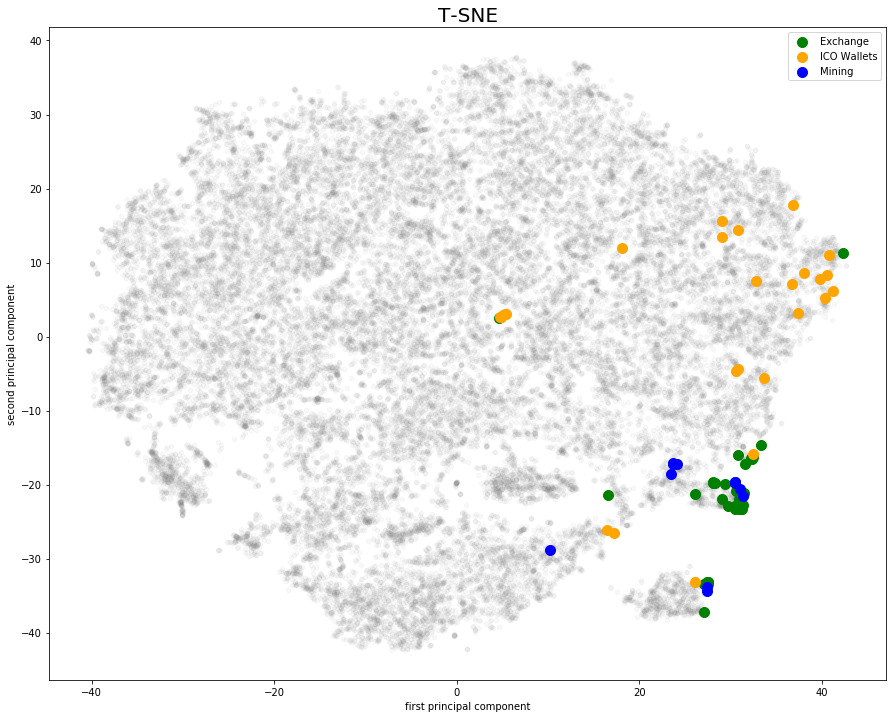

In [647]:

categs = ('Exchange', 'Mining', 'ICO Wallets')

subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
fig = plt.figure(figsize=(15,12))
#not labelled points
plt.scatter(not_subset[:,0], not_subset[:,1], s=20, c='gray', alpha=.05)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address']])#[address_mask] ]) #added address mask for all clusters

# # #labelled points

# ax = fig.add_subplot(111)
# ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c
    if np.sum(mask) >10:
        if c in categs:
            idx=categs.index(c)
            color = colors[idx]
            
        plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], s=100,c=color, alpha=1,label=lbl)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE', fontsize=20)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()



## TSNE 3D

In [740]:
time_start = time.time()
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_results_3d = tsne_3d.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.037s...
[t-SNE] Computed neighbors for 35917 samples in 15.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


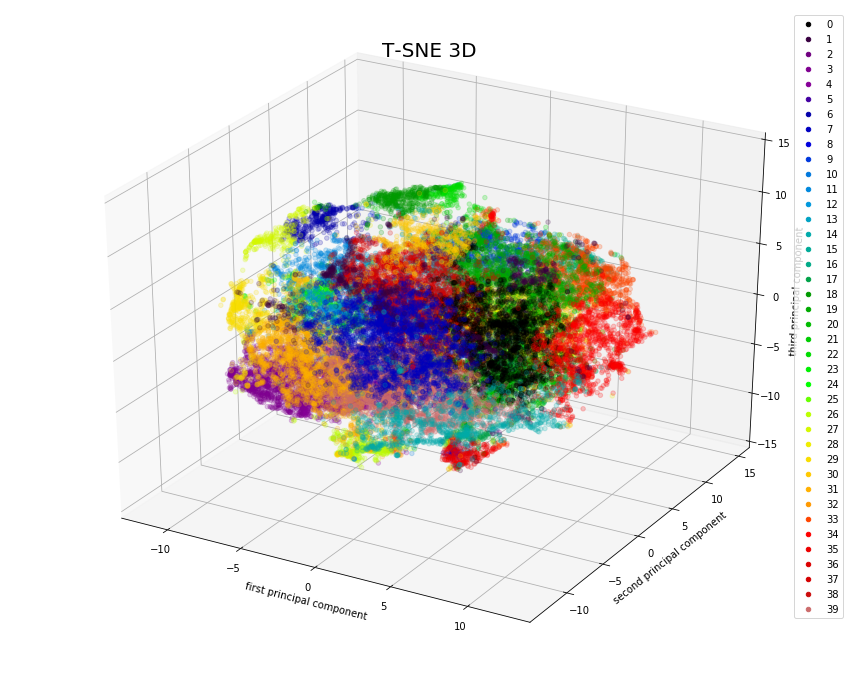

In [753]:
#color coded by cluster

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    ax.scatter(tsne_results_3d[mask][:,0], tsne_results_3d[mask][:,1],tsne_results_3d[mask][:,2], alpha=.2,label=lbl)
    
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)



ax.set_title('T-SNE 3D', fontsize=20)
ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
ax.set_zlabel('third principal component')
plt.show()

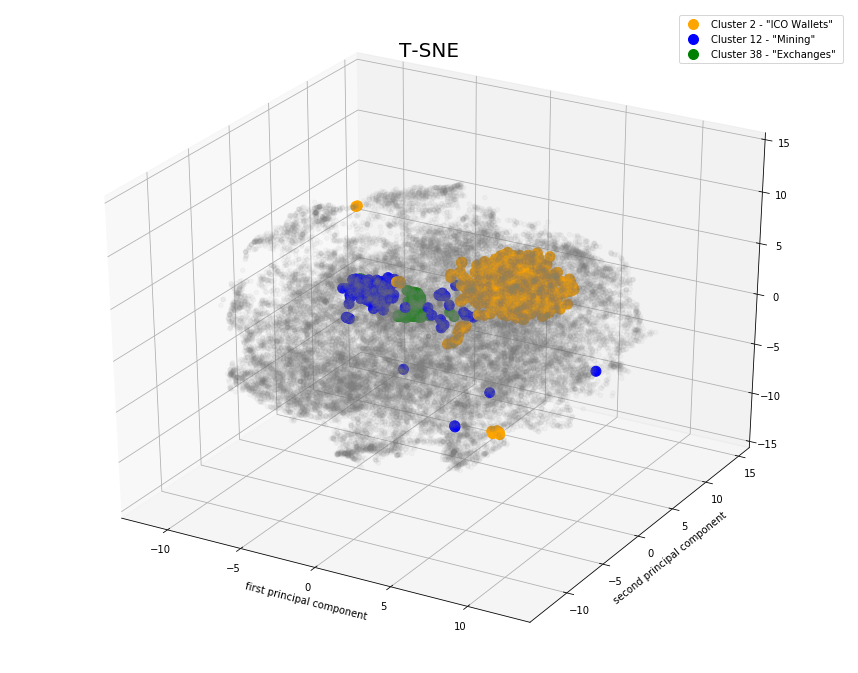

In [758]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    
    if c in clusters:
        idx = clusters.index(c)
        lbl = categ[idx]
        color = colors[idx]
        
        ax.scatter(tsne_results_3d[mask][:,0], tsne_results_3d[mask][:,1],tsne_results_3d[mask][:,2], s=100,c=color,alpha=1,label=('Cluster {} - "{}" '.format(c,lbl) ))
    else:
         ax.scatter(tsne_results_3d[mask][:,0], tsne_results_3d[mask][:,1],tsne_results_3d[mask][:,2], c='gray',s=20, alpha=.05)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)




plt.title('T-SNE', fontsize=20)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

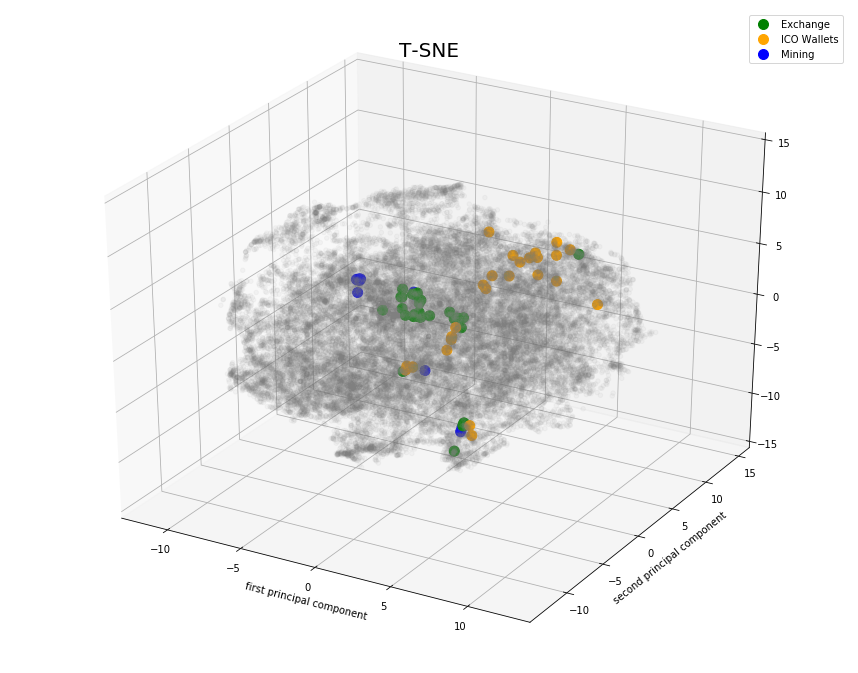

In [757]:
subset, not_subset  = tsne_results_3d[labelmask] , tsne_results_3d[~labelmask]
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
#not labelled points
ax.scatter(not_subset[:,0], not_subset[:,1],not_subset[:,2], s=20, c='gray', alpha=.05)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address']])#[address_mask] ]) #added address mask for all clusters

# # #labelled points

# ax = fig.add_subplot(111)
# ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c
    if np.sum(mask) >10:
        if c in categs:
            idx=categs.index(c)
            color = colors[idx]
            
        ax.scatter(tsne_results_3d[(labelmask & catmask)][:,0], tsne_results_3d[(labelmask & catmask)][:,1],tsne_results_3d[(labelmask & catmask)][:,2], s=100,c=color, alpha=1,label=lbl)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE', fontsize=20)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()